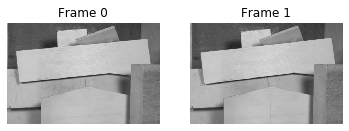

In [3]:
import cv2
import scipy.ndimage
import numpy as np
from matplotlib import pyplot as plt

from farneback.optical_flow import poly_exp, flow_iterative

image0 = cv2.imread("assets/Wooden/frame10.png", cv2.IMREAD_GRAYSCALE)
image1 = cv2.imread("assets/Wooden/frame11.png", cv2.IMREAD_GRAYSCALE)
images = [image0, image1]
show0 = cv2.cvtColor(images[0], cv2.COLOR_GRAY2RGB)
show1 = cv2.cvtColor(images[1], cv2.COLOR_GRAY2RGB)

fig = plt.figure(0)
showFig = fig.add_subplot(1, 2, 1)
plt.imshow(show0)
showFig.set_title("Frame 0")
showFig.axis('off')
showFig = fig.add_subplot(1, 2, 2)
plt.imshow(show1)
showFig.set_title("Frame 1")
showFig.axis('off')
plt.show()

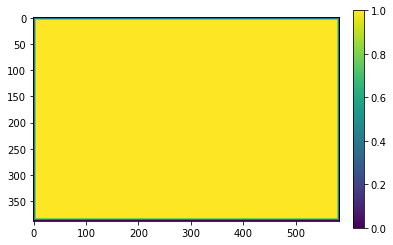

In [2]:
fig = plt.figure(1)

c0 = np.minimum(1, 1/5*np.minimum(np.arange(images[0].shape[0])[:, None], np.arange(images[1].shape[1])))
c0 = np.minimum(c0, 1/5*np.minimum(images[0].shape[0] - 1 - np.arange(images[0].shape[0])[:, None], images[0].shape[1] - 1 - np.arange(images[0].shape[1])))
c1 = c0

plt.imshow(c0)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

## Polynomial Expansion
Polynomial expansion approximates the neighborhood of each pixel for each frame as a quadratic polynomial. The polynomials are the basic representation of features in the algirithm. The basic form of quadratic polynomial is:
$$f(\mathbf{x}) \sim \mathbf{x}^T \mathbf{A x} + \mathbf{b}^T \mathbf{x} + c.$$
In the algorithm, there are two parameters: size of the pixel neighborhood and standard deviation of the Gaussian used to smooth derivatives used as a basis for the polynomial expansion, we set them 5 and 1.1 respectively.

In [3]:
sigma=4.0
sigma_flow=4.0
num_iter=3
model='constant'
mu=0

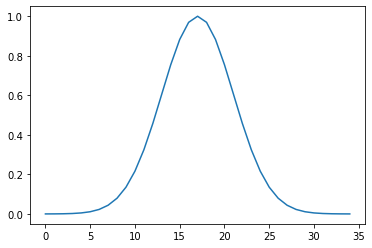

In [4]:
fig = plt.figure(2)

n = int(4*sigma + 1)
x = np.arange(-n, n + 1, dtype=np.int)
a = np.exp(-x**2 / (2 * sigma**2))  # a: applicability kernel [n]

plt.plot(a)
plt.show()

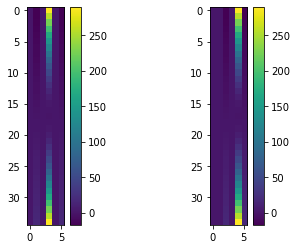

In [5]:
fig = plt.figure(3)

bx = np.stack([np.ones(a.shape), x, np.ones(a.shape), x**2, np.ones(a.shape), x], axis=-1)
by = np.stack([np.ones(a.shape), np.ones(a.shape), x, np.ones(a.shape), x**2, x], axis=-1)

showFig = fig.add_subplot(1, 2, 1)
plt.imshow(bx)
plt.colorbar(fraction=0.075, pad=0.04)
showFig = fig.add_subplot(1, 2, 2)
plt.imshow(by)
plt.colorbar(fraction=0.075, pad=0.04)
plt.show()

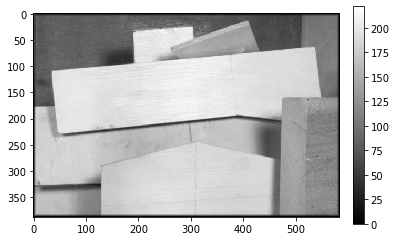

In [6]:
fig = plt.figure(4)

c0f = c0 * images[0]

plt.imshow(c0f, cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

(388, 584, 6)


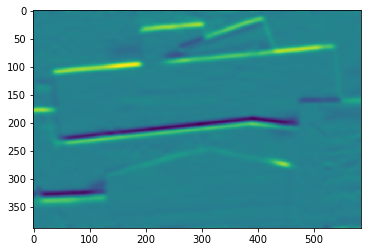

In [7]:
fig = plt.figure(4)

# G and v are used to calculate "r" from the paper: v = G*r
# r is the parametrization of the 2nd order polynomial for f
G = np.empty(list(images[0].shape) + [bx.shape[-1]]*2)
v = np.empty(list(images[0].shape) + [bx.shape[-1]])

# Apply separable cross-correlations

# Pre-calculate quantities recommended in paper
ab = np.einsum('i,ij->ij', a, bx)
abb = np.einsum('ij,ik->ijk', ab, bx)

# Calculate G and v for each pixel with cross-correlation
for i in range(bx.shape[-1]):
    for j in range(bx.shape[-1]):
        G[..., i, j] = scipy.ndimage.correlate1d(c0, abb[..., i, j], axis=0, mode='constant', cval=0)

    v[..., i] = scipy.ndimage.correlate1d(c0f, ab[..., i], axis=0, mode='constant', cval=0)

# Pre-calculate quantities recommended in paper
ab = np.einsum('i,ij->ij', a, by)
abb = np.einsum('ij,ik->ijk', ab, by)

# Calculate G and v for each pixel with cross-correlation
for i in range(bx.shape[-1]):
    for j in range(bx.shape[-1]):
        G[..., i, j] = scipy.ndimage.correlate1d(G[..., i, j], abb[..., i, j], axis=1, mode='constant', cval=0)

    v[..., i] = scipy.ndimage.correlate1d(v[..., i], ab[..., i], axis=1, mode='constant', cval=0)

# Solve r for each pixel
r = np.linalg.solve(G, v)

print(r.shape)
plt.imshow(r[ :, :, 1])

(388, 584, 2, 2)
(388, 584, 2)
(388, 584)


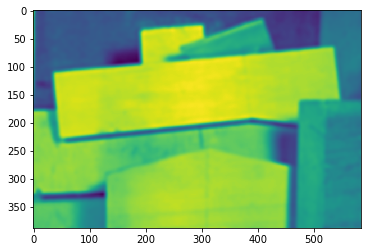

In [9]:
fig = plt.figure(5)

# Quadratic term
A0 = np.empty(list(images[0].shape) + [2, 2])
A0[..., 0, 0] = r[..., 3]
A0[..., 0, 1] = r[..., 5] / 2
A0[..., 1, 0] = A0[..., 0, 1]
A0[..., 1, 1] = r[..., 4]

# Linear term
B0 = np.empty(list(images[0].shape) + [2])
B0[..., 0] = r[..., 1]
B0[..., 1] = r[..., 2]

# constant term
C0 = r[..., 0]

# b: [n, n, 6]
# r: [f, f, 6]
# f: [f, f]
# e = b*r - f

print(A0.shape)
print(B0.shape)
print(C0.shape)
plt.imshow(C0)

In [10]:
A1, B1, C1 = poly_exp(images[1], c1, sigma)

## Displacement Estimation
Overall the algorithm works in the following way:
![workflow](assets/workflow.png "Workflow")
with the approximated $\mathbf{A}_i$ and $\mathbf{b}_i$ from polynomial expansion, we can calculate the translation vector $\mathbf{d}_i$ with the assumption:
$$f_2(\mathbf{x})=f_1(\mathbf{x-d}).$$
Intuitively, expand the coefficients of quadratic polynomials, we should get:
$$
\mathbf{A_2=A_1\\
b_2=b_1-2A_1d}\\
c_2=\mathbf{d}^T\mathbf{A_1d - (b_1)}^T\mathbf{d} + c_1.
$$
However, the above assumption is too strong to be applicable, so a few
$$
\mathbf{A(x) = \cfrac{A_1(x) + A_2(x)}{2}\\
\Delta b(x) = -\cfrac{1}{2} (b_2(x)-b_1(x))}
$$
so
$$\mathbf{A(x)d(x) = \Delta b(x)}$$

In [11]:
d = None

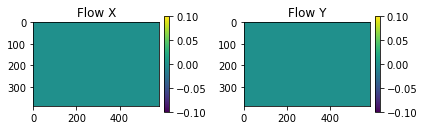

In [12]:
fig = plt.figure(6)

# Pixel coordinates of each point in the images
x = np.stack(np.broadcast_arrays(np.arange( images[0].shape[0])[:, None], np.arange(images[0].shape[1]) ), axis=-1).astype(np.int)

# Initialize displacement field
if d is None:
    d = np.zeros(list(images[0].shape) + [2])

showFig = fig.add_subplot(1, 2, 1)
plt.imshow(d[ :, :, 0])
showFig.set_title("Flow X")
plt.colorbar(fraction=0.035, pad=0.04)
showFig = fig.add_subplot(1, 2, 2)
plt.imshow(d[ :, :, 1])
showFig.set_title("Flow Y")
plt.colorbar(fraction=0.035, pad=0.04)
plt.tight_layout()
plt.show()

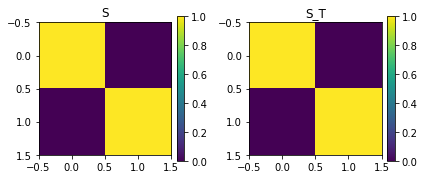

In [13]:
fig = plt.figure(7)

# Set up applicability convolution window
n_flow = int(4*sigma_flow + 1)
xw = np.arange(-n_flow, n_flow + 1)
w = np.exp(-xw**2 / (2 * sigma_flow**2))

# Evaluate warp parametrization model at pixel coordinates
if model == 'constant':
    S = np.eye(2)

elif model in ('affine', 'eight_param'):
    S = np.empty(list(x.shape) + [6 if model == 'affine' else 8])

    S[..., 0, 0] = 1
    S[..., 0, 1] = x[..., 0]
    S[..., 0, 2] = x[..., 1]
    S[..., 0, 3] = 0
    S[..., 0, 4] = 0
    S[..., 0, 5] = 0

    S[..., 1, 0] = 0
    S[..., 1, 1] = 0
    S[..., 1, 2] = 0
    S[..., 1, 3] = 1
    S[..., 1, 4] = x[..., 0]
    S[..., 1, 5] = x[..., 1]

    if model == 'eight_param':
        S[..., 0, 6] = x[..., 0] ** 2
        S[..., 0, 7] = x[..., 0] * x[..., 1]

        S[..., 1, 6] = x[..., 0] * x[..., 1]
        S[..., 1, 7] = x[..., 1] ** 2

else:
    raise ValueError('Invalid parametrization model')

S_T = S.swapaxes(-1, -2)

showFig = fig.add_subplot(1, 2, 1)
plt.imshow(S)
showFig.set_title("S")
plt.colorbar(fraction=0.05, pad=0.04)
showFig = fig.add_subplot(1, 2, 2)
plt.imshow(S_T)
showFig.set_title("S_T")
plt.colorbar(fraction=0.05, pad=0.04)
plt.tight_layout()
plt.show()

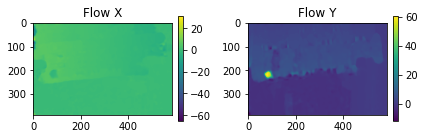

In [14]:
fig = plt.figure(8)

# Iterate convolutions to estimate the optical flow
for _ in range(num_iter):
    # Set d~ as displacement field fit to nearest pixel (and constrain to not
    # being off image). Note we are setting certainty to 0 for points that
    # would have been off-image had we not constrained them
    d_ = d.astype(np.int)
    x_ = x + d_

    # x_ = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)

    # Constrain d~ to be on-image, and find points that would have
    # been off-image
    x_2 = np.maximum(np.minimum(x_, np.array(images[0].shape) - 1), 0)
    off_f = np.any(x_ != x_2, axis=-1)
    x_ = x_2

    # Set certainty to 0 for off-image points
    c_ = c1[x_[..., 0], x_[..., 1]]
    c_[off_f] = 0

    # Calculate A and delB for each point, according to paper
    A = (A0 + A1[x_[..., 0], x_[..., 1]]) / 2
    A *= c_[..., None, None]  # recommendation in paper: add in certainty by applying to A and delB

    delB = -1/2 * (B1[x_[..., 0], x_[..., 1]] - B0) + (A @ d_[..., None])[..., 0]
    delB *= c_[..., None]  # recommendation in paper: add in certainty by applying to A and delB

    # Pre-calculate quantities recommended by paper
    A_T = A.swapaxes(-1, -2)
    ATA = S_T @ A_T @ A @ S
    ATb = (S_T @ A_T @ delB[..., None])[..., 0]
    # btb = delB.swapaxes(-1, -2) @ delB

    # If mu is 0, it means the global/average parametrized warp should not be
    # calculated, and the parametrization should apply to the local calculations
    if mu == 0:
        # Apply separable cross-correlation to calculate linear equation
        # for each pixel: G*d = h
        G = scipy.ndimage.correlate1d(ATA, w, axis=0, mode='constant', cval=0)
        G = scipy.ndimage.correlate1d(G, w, axis=1, mode='constant', cval=0)

        h = scipy.ndimage.correlate1d(ATb, w, axis=0, mode='constant', cval=0)
        h = scipy.ndimage.correlate1d(h, w, axis=1, mode='constant', cval=0)

        d = (S @ np.linalg.solve(G, h)[..., None])[..., 0]

    # if mu is not 0, it should be used to regularize the least squares problem
    # and "force" the background warp onto uncertain pixels
    else:
        # Calculate global parametrized warp
        G_avg = np.mean(ATA, axis=(0, 1))
        h_avg = np.mean(ATb, axis=(0, 1))
        p_avg = np.linalg.solve(G_avg, h_avg)
        d_avg = (S @ p_avg[..., None])[..., 0]

        # Default value for mu is to set mu to 1/2 the trace of G_avg
        if mu is None:
            mu = 1/2 * np.trace(G_avg)

        # Apply separable cross-correlation to calculate linear equation
        G = scipy.ndimage.correlate1d(A_T @ A, w, axis=0, mode='constant', cval=0)
        G = scipy.ndimage.correlate1d(G, w, axis=1, mode='constant', cval=0)

        h = scipy.ndimage.correlate1d((A_T @ delB[..., None])[..., 0], w, axis=0, mode='constant', cval=0)
        h = scipy.ndimage.correlate1d(h, w, axis=1, mode='constant', cval=0)

        # Refine estimate of displacement field
        d = np.linalg.solve(G + mu*np.eye(2), h + mu*d_avg)

    # TODO: return global displacement parameters and/or global displacement if mu != 0
showFig = fig.add_subplot(1, 2, 1)
plt.imshow(d[ :, :, 0])
showFig.set_title("Flow X")
plt.colorbar(fraction=0.035, pad=0.04)
showFig = fig.add_subplot(1, 2, 2)
plt.imshow(d[ :, :, 1])
showFig.set_title("Flow Y")
plt.colorbar(fraction=0.035, pad=0.04)
plt.tight_layout()
plt.show()